## `fit_residuals.ipynb`
Notebook by Tim Bartholomaus, June 18, 2019

Goal of notebook is to plot residuals between a reference profile/surface as a function of space and time, and then fit a smooth, interpolated surface through these residuals.

Residuals are expected in a dictionary, `res` with keys `"x"`, `"t"`, and `"off"`, in which `x` is position along the profile, `t` is the relative time of the residual measurement, and `off` is the measured offset between the ICESat-2 measurement and the reference surface elevation.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import interpolate

import sys
sys.path.insert(0, '~/gridding/notebook')
# import utils

# print(sys.path)

In [2]:
print(sys.path)

['~/gridding/notebook', '/srv/conda/lib/python36.zip', '/srv/conda/lib/python3.6', '/srv/conda/lib/python3.6/lib-dynload', '', '/srv/conda/lib/python3.6/site-packages', '/srv/conda/lib/python3.6/site-packages/IPython/extensions', '/home/jovyan/.ipython']


#### Create synthetic residuals that are a function of length along the profile `x`, and time `t`

In [3]:
# n_residuals = 30
# max_length = 50*1000 # m
# max_time = 100 # d
# max_off = 100 # m


# res = dict()
# res['x'] = max_length * np.random.rand(n_residuals) # m
# res['t'] = max_time * np.random.rand(n_residuals) # d

# noise = np.random.randn(n_residuals) * 20 # m

# off_scalar = max_off / (max_length*max_time)
# res['off'] = off_scalar * res['x']*res['t'] + noise # create the synthetic residuals, with noise

#### Read in measured residuals that are a function of length along the profile `x`, and time `t`

In [115]:
atm_date = '2014-04-29'
atm_date = '2018-04-18'

data_prod_path = '../data_prod/'
# intersections_filename = 'Intersections_ATM20180418.csv'
intersections_filename = 'Intersections_ATM'+atm_date[0:4] + atm_date[5:7] + atm_date[8:10] + '.csv'
res = pd.read_csv(data_prod_path + intersections_filename, parse_dates=[4]) 

# res.dtypes

res['off'] = res['z_ATL06'] - res['ATM_elev']
res['t'] = res['t_ATL06'] - pd.to_datetime(atm_date)
res['t_days'] = res['t'].astype('timedelta64[D]')
res.rename(columns={'dist_along': "x"}, inplace=True)


res.head()
# res.columns

# pd.to_datetime(atm_date)

,x,ATM_elev,idx_ATM,z_ATL06,t_ATL06,idx_ATL06,gt_ATL06,off,t,t_days
0,125293.549537,36.6189,3399.0,35.714657,2019-02-15 10:09:55,1578.0,gt1l,-0.904243,303 days 10:09:55,303.0
1,125388.182985,35.0684,3402.0,34.106010,2019-02-15 10:09:55,4933.0,gt1r,-0.962390,303 days 10:09:55,303.0
2,96217.510032,88.3644,2580.0,66.844490,2019-01-16 01:09:49,39471.0,gt3r,-21.519910,273 days 01:09:49,273.0
3,102715.054408,30.4860,2761.0,29.333950,2019-01-16 01:09:49,19993.0,gt1l,-1.152050,273 days 01:09:49,273.0
4,102652.754159,33.3447,2759.0,38.831944,2019-01-16 01:09:49,23915.0,gt1r,5.487244,273 days 01:09:49,273.0


In [109]:

# n_residuals = 30
# max_length = 50*1000 # m
# max_time = 100 # d
# max_off = 100 # m


# res = dict()
# res['x'] = max_length * np.random.rand(n_residuals) # m
# res['t'] = max_time * np.random.rand(n_residuals) # d

# noise = np.random.randn(n_residuals) * 20 # m

# off_scalar = max_off / (max_length*max_time)
# res['off'] = off_scalar * res['x']*res['t'] + noise # create the synthetic residuals, with noise

#### Spatio-temporal (2-D) interpolation
Right now, the radial basis functions seem to perform best

In [10]:
# Create a mesh of the space and time variables
grid_x, grid_t = np.mgrid[0:max_length:100j, 
                          0:max_time:100j] # create a grid from 0 to max_length and 0 to
                                           #  max_time, with the j number of steps

# This griddata is too strict
grid_off = interpolate.griddata((res['x'], res['t']), res['off'], 
                                (grid_x, grid_t), method='cubic')

# # tck = interpolate.bisplrep(res['x'], res['t'], res['off'], s=2)
# # grid_off = interpolate.bisplev(grid_x[:,0], grid_t[0,:], tck)

# # f = interpolate.interp2d(res['x'], res['t'], res['off'], kind='cubic')
# # grid_off = f(grid_x[:,0], grid_t[0,:])

# Radial basis functions
x_stan = res['x']/max_length
t_stan = res['t']/max_time
rbf = interpolate.Rbf(x_stan, t_stan, res['off'], epsilon=.01)
        # epsilon defines the stiffness of the fitting routine. High values are stiff surfaces
grid_x_stan = grid_x/max_length
grid_t_stan = grid_t/max_time
grid_off = rbf(grid_x_stan, grid_t_stan)


# # Kriging
# # Function does not like NaN's, so lets remove them
# # xp, yp, zp = x[~np.isnan(z)], y[~np.isnan(z)], z[~np.isnan(z)]
# Run kriging interpolator, with 1 m RMSE noise added to the diagonal (np.ones(xp.shape)*1)
# grid_off_lsc, e_lsc = utils.lscip(res['x'], res['t'], res['off'], np.ones(res['x'].shape)*1, grid_x, grid_t, n=10, d=1e3, a=25e3)[0:2]

In [89]:
rbf.epsilon

res['t'].to_datetime64()# .astype('np.datetime64['d']')

AttributeError: 'Series' object has no attribute 'to_datetime64'

#### Plotting

In [118]:
%matplotlib widget
plt.figure(figsize=(10,6))
# plt.contourf(grid_x/1000, grid_t, (grid_off))
plt.scatter(res['x'].values/1000, res['t_days'].values, s = 20, c=res['off'].values,
            linewidth=.5, edgecolor='k', vmin = -50, vmax=10, cmap='inferno')
# res.plot.scatter(x='x', y='t', c='off')#, linewidth=.5, edgecolor='k')
plt.xlabel('Profile Length (km)')
plt.ylabel('Time (days)')
# plt.colormap('RdBu')
plt.colorbar(label='Deviation from reference profile (m)');
plt.show()

FigureCanvasNbAgg()

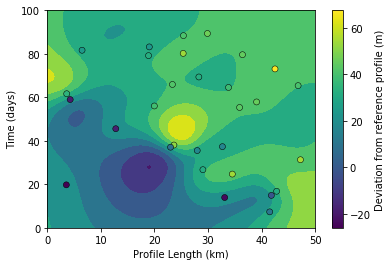

In [9]:
# fig, ax = plt.subplots(3)

plt.figure()
plt.contourf(grid_x/1000, grid_t, (grid_off))
plt.scatter(res['x']/1000, res['t'], c=res['off'], linewidth=.5, edgecolor='k')
plt.xlabel('Profile Length (km)')
plt.ylabel('Time (days)')
plt.colorbar(label='Deviation from reference profile (m)');
plt.show()